In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as torch_datasets
import imgaug.augmenters as iaa

from models import LAVAE, torch_dataloader, torch_latent_dataloader
import utils as ut

# Autoreload modules
%load_ext autoreloads
%autoreload 2


/var/folders/n7/b5dt_rrd5dv7z7wz4pl21bzc0000gn/T/ipykernel_16089/213252538.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


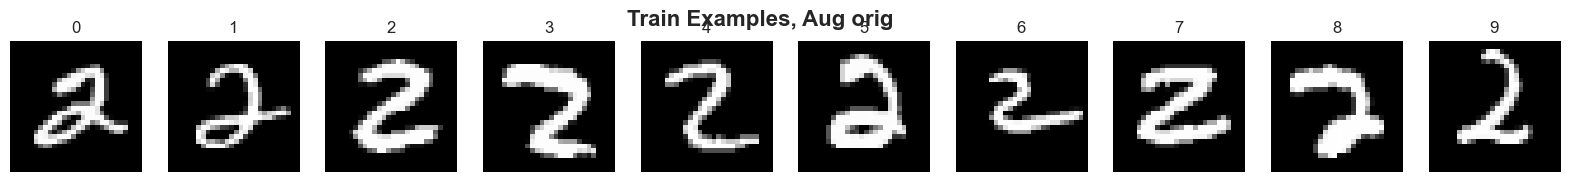

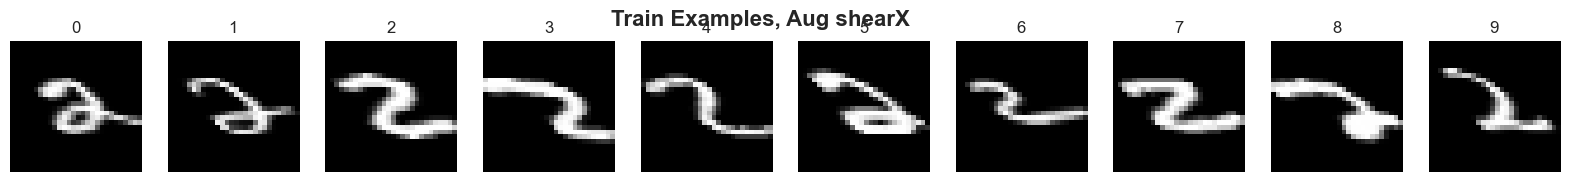

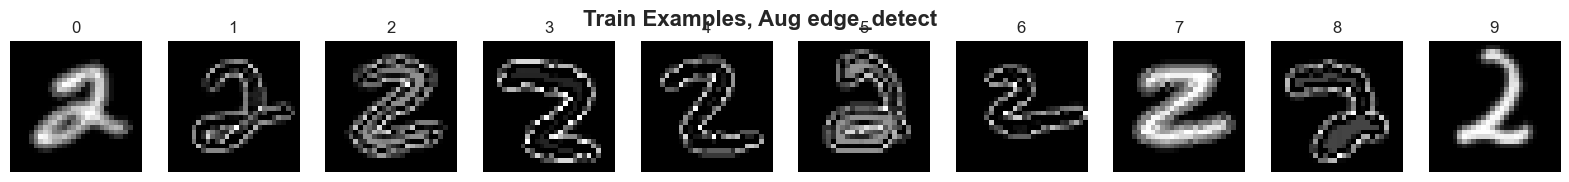

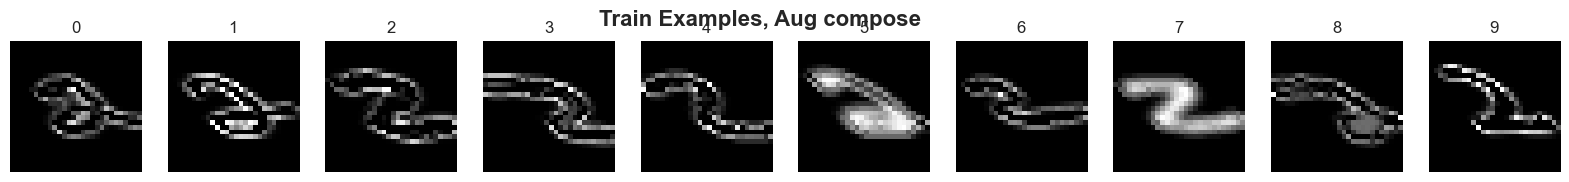

In [26]:
AUGS = ['shearX','edge_detect']

train_loader, test_loader = ut.MNIST_data(2,augs=AUGS,combine=False)

In [90]:
len(torch.split(test_data, test_data.shape[0]//2))

2

In [ ]:
train_data = train_set.data
test_data = test_set.data

for a in augs: 

    train_list = [train_data]
    test_list = [test_data]

    if a == 'flip_ud': 
        train_list.append(torch.flip(train_data, dims=[1]))
        test_list.append(torch.flip(test_data, dims=[1]))

    elif a == 'flip_lr':
        train_list.append(torch.flip(train_data, dims=[2]))
        test_list.append(torch.flip(test_data, dims=[2]))

    elif a == 'rotate_cw':
        train_list.append(torch.rot90(train_data, k=-1, dims=[1,2]))
        test_list.append(torch.rot90(test_data, k=-1, dims=[1,2]))

    elif a == 'rotate_ccw':
        train_list.append(torch.rot90(train_data, k=1, dims=[1,2]))
        test_list.append(torch.rot90(test_data, k=1, dims=[1,2]))

    elif a == 'gaussian_blur':
        aug = transforms.GaussianBlur(7, sigma=(0.1, 2.0))

        train_list.append(aug(train_data))
        test_list.append(aug(test_data))

    elif a == 'edge_detect':
        aug = iaa.EdgeDetect(alpha=(0.0, 1))

        train_list.append(torch.from_numpy(aug.augment_images(train_data.numpy())))
        test_list.append(torch.from_numpy(aug.augment_images(test_data.numpy())))

    elif a == 'shear':
        aug = iaa.ShearX((-50, -45))

        train_list.append(torch.from_numpy(aug.augment_images(train_data.numpy())))
        test_list.append(torch.from_numpy(aug.augment_images(test_data.numpy())))

    elif a == 'canny':
        aug = iaa.Canny(alpha=1,    colorizer=iaa.RandomColorsBinaryImageColorizer(
                            color_true=0,
                            color_false=255
                        ))

        train_list.append(torch.from_numpy(aug.augment_images(train_data.numpy())))
        test_list.append(torch.from_numpy(aug.augment_images(test_data.numpy())))

    elif a == 'mini_image':
        aug = transforms.Resize(8)

        copy = train_data.clone()
        copy[:,0:8,0:8] = aug(train_data)
        train_list.append(copy)

        copy = test_data.clone()
        copy[:,0:8,0:8] = aug(test_data)
        test_list.append(copy)

    elif a == 'tl_sap_noise': 
        noisy_train = train_data.clone()
        noise = (128 + 32 * torch.randn((noisy_train.shape[0], noisy_train.shape[1] // 4, noisy_train.shape[2] // 4))).to(torch.uint8)
        noisy_train[:, :noisy_train.shape[1] // 4, :noisy_train.shape[2] // 4] += noise
        train_list.append(noisy_train)

        noisy_test = test_data.clone()
        noise = (128 + 32 * torch.randn((noisy_test.shape[0], 
                                            noisy_test.shape[1] // 4, 
                                            noisy_test.shape[2] // 4))).to(torch.uint8)
        noisy_test[:, :noisy_test.shape[1] // 4, :noisy_test.shape[2] // 4] += noise
        test_list.append(noisy_test)

    elif a == 'sap_noise': 
        noisy_train = train_data.clone()
        noisy_mask = torch.rand(noisy_train.size()) < 0.2
        noise = (128 + 16 * torch.randn(noisy_train.size())).to(torch.int8)
        noisy_train[noisy_mask] += noise[noisy_mask]
        train_list.append(noisy_train)

        noisy_test = test_data.clone()
        noisy_mask = torch.rand(noisy_test.size()) < 0.2
        noise = (128 + 16 * torch.randn(noisy_test.size())).to(torch.int8)
        noisy_test[noisy_mask] += noise[noisy_mask]
        test_data.append(noisy_test)

    else: 
        raise ValueError('augmentation currently not supported')

    train_data = torch.cat(train_list, dim=0)
    test_data = torch.cat(test_list, dim=0)


# Create Dataloaders
if combine:
    train_data = torch.cat(train_list, dim=0)
    test_data = torch.cat(test_list, dim=0)

    train_set = torch_dataloader(train_data,transform=trans)
    test_set = torch_dataloader(train_data,transform=trans)

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=shuffle)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=shuffle)

    if Plot:
        plot_images(train_set.data, n_images=10, image_dim=28,title='Train Examples')
        plot_images(test_set.data, n_images=10, image_dim=28, title='Test Examples')

else:
    if len(augs) == 1:
        
        train_arrays = {'orig': train_list[0]}
        test_arrays = {'orig': test_list[0]}

        train_arrays = {aug[0]: train_list[1]}
        test_arrays = {aug[0]: test_list[1]}

    elif len(aug) == 2:

        train_list_1 = torch.split(train_list[0], train_list[0].shape[0]//2)

        train_arrays = {'orig': train_list_1[0]}
        test_arrays = {'orig': train_list_1[0]}

        train_arrays = {aug[0]: train_list_1[1]}
        test_arrays = {aug[0]: train_list_1[1]}

        train_list_2 = torch.split(train_list[1], train_list[1].shape[0]//2)

        train_arrays = {aug[1]: train_list_2[0]}
        test_arrays = {aug[1]: train_list_2[0]}

        train_arrays = {'compose': train_list_2[1]}
        test_arrays = {'compose': train_list_2[1]}

    train_set = torch_latent_dataloader(train_arrays,transform=trans)
    test_set = torch_latent_dataloader(test_arrays,transform=trans)

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)


    if Plot:
        for a,data in train_set.data_arrays.items(): 
            plot_images(data, indices = np.arange(10), n_images=10, image_dim=28,title='Train Examples, Aug {}'.format(a))


